# Data Preparation


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import re
import unicodedata
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.isri import ISRIStemmer
from snowballstemmer import stemmer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer 
import math
import gensim
import tensorflow
from nltk import ngrams
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow
from keras import losses
from keras import metrics
from keras import optimizers
import keras
from keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix

In [2]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Import data
df = pd.read_csv('gdrive/My Drive/Colab Notebooks/Emotional-Tone-Dataset.csv')
pd.set_option('display.max_colwidth', 500)

In [5]:
#check and test
df.head()

,ID,TWEET,LABEL
0,1,الاوليمبياد الجايه هكون لسه ف الكليه ..,none
1,2,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني لسه اقل من 7 % و نفلس و بهايم لسه يتابعوا الاوليمبياد,anger
2,3,كتنا نيله ف حظنا الهباب xD,sadness
3,4,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حراسه المرمي...,joy
4,5,الاوليمبياد نظامها مختلف .. ومواعيد المونديال مكانتش مقرفه ولا حاجه كانت معقوله,none


In [6]:
# Structure of the dataset
df.shape

(10065, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10065 entries, 0 to 10064
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10065 non-null  int64 
 1    TWEET  10064 non-null  object
 2    LABEL  10065 non-null  object
dtypes: int64(1), object(2)
memory usage: 236.0+ KB


In [8]:
print("We need to classify "+ str(df[" LABEL"].nunique()) +" emotions.")
print("The emotions to be classified are: "+ str(list(df[" LABEL"].unique().tolist())))

We need to classify 8 emotions.
The emotions to be classified are: ['none', 'anger', 'sadness', 'joy', 'surprise', 'love', 'sympathy', 'fear']


In [9]:
# Check balanced
df[" LABEL"].value_counts()

none        1550
anger       1444
joy         1281
sadness     1256
love        1220
fear        1207
sympathy    1062
surprise    1045
Name:  LABEL, dtype: int64

In [10]:
# Create copies of original 
df_clean = df.copy()

In [11]:
# check null values
df_clean.isnull().sum()

ID        0
 TWEET    1
 LABEL    0
dtype: int64

In [12]:
# Drop null values
df_clean = df_clean.dropna()
df_clean = df_clean.reset_index(drop=True)

In [13]:
df_clean.isnull().sum()

ID        0
 TWEET    0
 LABEL    0
dtype: int64

# Text Cleaning pipeline

In [14]:
def normalize_arabic(text):
    text = re.sub("إ", "ا", text)
    text = re.sub("أ", "ا", text)
    text = re.sub("آ", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                         """, re.VERBOSE)
    text = re.sub(arabic_diacritics, '', text)
    return text

def remove_punctuations(text):
    arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ»«•'''
    english_numbers = "0123456789"
    english_punctuations = string.punctuation
    punctuations_list = arabic_punctuations + english_numbers + english_punctuations
    
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)  

# Remove english
def remove_english(text):
    text = re.sub(r'\s*[A-Za-z]+\b', '' , text)
    return text.rstrip()

def text2words(text):
  return word_tokenize(text)    

def remove_stopwords(words, stop_words):
    return [word for word in words if word not in stop_words]

def to_lowercase(text):
    return text.lower()

def rooting(text):
    result = list()
    for word in text:
        stemmer = ISRIStemmer()
        result.append(stemmer.stem(word))
    return result

def normalize_text(text):
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_punctuations(text)
    text = remove_repeating_char(text)
    text = remove_english(text)
    text = to_lowercase(text)
    words = text2words(text)
    arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))
    words = remove_stopwords(words, arb_stopwords)
    #words = rooting(words)
    
    return words  #' '.join(words)


## Text Preprocessing

In [15]:
df_clean[' TWEET'] = df_clean[' TWEET'].apply(normalize_text)

In [16]:
# del df_clean['ID']
df_clean.to_csv("cleaned_Emotional.csv",index=None)

In [17]:
df2 = pd.read_csv("cleaned_Emotional.csv")
df2 = df2.dropna()
df2 = df2.reset_index(drop=True)
df2.head(n=3)

,ID,TWEET,LABEL
0,1,"['الاوليمبياد', 'الجايه', 'هكون', 'لسه', 'ف', 'الكليه']",none
1,2,"['عجز', 'الموازنه', 'وصل', 'ل', 'الناتج', 'المحلي', 'يعني', 'لسه', 'اقل', 'و', 'نفلس', 'و', 'بهايم', 'لسه', 'يتابعوا', 'الاوليمبياد']",anger
2,3,"['كتنا', 'نيله', 'ف', 'حظنا', 'الهباب']",sadness


In [18]:
X, y = df2[' TWEET'].to_list(), df2[' LABEL'].to_list()

# Vectorization
# pre-trained aravec

In [19]:
#Encoding output labels
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
# convert integers to one hot encoded
y_categorical = np_utils.to_categorical(encoded_y)    

In [20]:
y_categorical[2]

array([0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size = 0.33, random_state=42)

In [22]:
X_train[33]

"['الفشل', 'عندما', 'نقول', 'لناس', 'كلمه', 'فاشل', 'الفشل', 'الحقيقي', 'عمره', 'ماكان', 'احد', 'فاشل', 'نحطم', 'الناس', 'قبل', 'الفشل', 'الحقيقي', 'انا', 'ضدالفشل', 'افشل', 'مدرب', 'مر', 'علي', 'ناديك']"

In [23]:
!unzip 'gdrive/My Drive/Colab Notebooks/full_grams_sg_300_twitter.zip'

Archive:  gdrive/My Drive/Colab Notebooks/full_grams_sg_300_twitter.zip
  inflating: full_grams_sg_300_twitter.mdl  
  inflating: full_grams_sg_300_twitter.mdl.trainables.syn1neg.npy  
  inflating: full_grams_sg_300_twitter.mdl.wv.vectors.npy  


In [24]:
t_model = gensim.models.Word2Vec.load('full_grams_sg_300_twitter.mdl')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [25]:
from googleapiclient.discovery import build

vector_sz = 300 #vector for each word
number_of_inputs = 140 #max number of words per tweet

def encoded_docs(sent_tokens):
    sent_emb = np.zeros(shape=(number_of_inputs, vector_sz)) #np array of arrays (array of 100/300 float number per word)
    sent_emb_index = 0
    for i in range(len(sent_tokens)):
        try:
            sent_emb[sent_emb_index] = t_model.wv[sent_tokens[i]]
            sent_emb_index = sent_emb_index + 1
        except:
            try:
                result = rooting([sent_tokens[i]])[0]
                embedded_vectors[sent_emb_index] = t_model.wv[result]
                sent_emb_index = sent_emb_index + 1
            except:
                try:
                    #print("in google search " + sent_tokens[i])
                    search_output = google_search(sent_tokens[i])  
                    #print("search_output " + search_output)
                    tokens = re.split(" ", search_output)
                    for j in range(len(tokens)):
                        try:
                            sent_emb[sent_emb_index] = t_model.wv[tokens[j]]
                            sent_emb_index = sent_emb_index + 1
                            print ("added " + tokens[j])
                        except:
                            pass
                except:
                     pass #currently emojis can't be embedded and for any extreme case
    return sent_emb    

In [26]:
em_train = np.zeros(shape=(len(X_train), number_of_inputs, vector_sz))#number of tweets*max number of words per tweet*vector size per word
em_test = np.zeros(shape=(len(X_test), number_of_inputs, vector_sz))

for i in range(len(X_train)):
    em_train[i]= encoded_docs(X_train[i])

for i in range(len(X_test)):
    em_test[i]= encoded_docs(X_test[i])

In [27]:
print(em_train.shape)
print(y_train.shape)
print(em_test.shape)
print(y_test.shape)

(6742, 140, 300)
(6742, 8)
(3322, 140, 300)
(3322, 8)


# CNN Model

In [28]:
import keras
import random
from keras.models import Sequential
from keras.callbacks import TensorBoard
import csv
import numpy as np

dropout_rate = 0.3
number_of_inputs = 140 #max number of words /characters per doc(tweet)
vector_size = 300 #vector for each word
batch_size = 15
kernal_size= 5
pool_size = 3
noise_shape = (batch_size, 1, number_of_inputs)
epochs = 20
test_size = 0.33
Learning_rate = 0.0001
# Make model


model = Sequential()

#Convolution
model.add(keras.layers.Conv1D(filters= vector_size, kernel_size=kernal_size, strides=1, padding='same', activation="relu",
                              input_shape=(number_of_inputs, vector_size)))
model.add(keras.layers.Conv1D(filters= vector_size, kernel_size= kernal_size, strides=1, padding='same', activation="relu"))
model.add(keras.layers.MaxPooling1D(pool_size =  pool_size, padding='same'))

#Convolution
model.add(keras.layers.Conv1D(filters= vector_size, kernel_size= kernal_size, strides=1, padding='same', activation="relu"))
model.add(keras.layers.Conv1D(filters= vector_size, kernel_size= kernal_size, strides=1, padding='same', activation="relu"))
model.add(keras.layers.MaxPooling1D(pool_size = pool_size, padding='same'))

#Convolution
model.add(keras.layers.Conv1D(filters= vector_size, kernel_size= kernal_size, strides=1, padding='same', activation="relu"))
model.add(keras.layers.Conv1D(filters= vector_size, kernel_size= kernal_size, strides=1, padding='same', activation="relu"))
model.add(keras.layers.MaxPooling1D(pool_size = pool_size, padding='same'))

#Convolution
model.add(keras.layers.Conv1D(filters= vector_size, kernel_size= kernal_size, strides=1, padding='same', activation="relu"))
model.add(keras.layers.Conv1D(filters= vector_size, kernel_size= kernal_size, strides=1, padding='same', activation="relu"))
model.add(keras.layers.MaxPooling1D(pool_size = pool_size, padding='same'))

#Convolution
model.add(keras.layers.Conv1D(filters= vector_size, kernel_size= kernal_size, strides=1, padding='same', activation="relu"))
model.add(keras.layers.Conv1D(filters= vector_size, kernel_size= kernal_size, strides=1, padding='same', activation="relu"))
model.add(keras.layers.MaxPooling1D(pool_size = pool_size, padding='same'))


#Dropout
model.add(keras.layers.Dropout(dropout_rate))

#output
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(8, activation="softmax"))

In [29]:
opt = keras.optimizers.Adam(lr= Learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer= opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 140, 300)          450300    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 140, 300)          450300    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 47, 300)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 47, 300)           450300    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 47, 300)           450300    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 300)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 16, 300)           4

### Train the model


In [31]:
history = model.fit(em_train,
                    y_train,
                    batch_size= batch_size,
                    epochs= epochs,
                    validation_data=(em_test, y_test),
                    shuffle=True)
model.save("emotion_model.h5")

Epoch 1/20
450/450 [==============================] - 278s 618ms/step - loss: 1.8895 - accuracy: 0.2550 - val_loss: 1.5908 - val_accuracy: 0.3928
Epoch 2/20
450/450 [==============================] - 239s 532ms/step - loss: 1.5524 - accuracy: 0.3966 - val_loss: 1.5222 - val_accuracy: 0.4157
Epoch 3/20
450/450 [==============================] - 257s 572ms/step - loss: 1.5244 - accuracy: 0.4080 - val_loss: 1.5084 - val_accuracy: 0.4229
Epoch 4/20
450/450 [==============================] - 274s 608ms/step - loss: 1.5052 - accuracy: 0.4149 - val_loss: 1.5040 - val_accuracy: 0.4217
Epoch 5/20
450/450 [==============================] - 240s 533ms/step - loss: 1.4732 - accuracy: 0.4244 - val_loss: 1.4815 - val_accuracy: 0.4302
Epoch 6/20
450/450 [==============================] - 273s 606ms/step - loss: 1.4231 - accuracy: 0.4565 - val_loss: 1.3875 - val_accuracy: 0.4621
Epoch 7/20
450/450 [==============================] - 262s 583ms/step - loss: 1.2889 - accuracy: 0.5215 - val_loss: 1.2980 -

In [32]:
model = load_model("emotion_model.h5")

In [33]:
model.evaluate(em_test, y_test)

104/104 [==============================] - 32s 311ms/step - loss: 2.3289 - accuracy: 0.5340


[2.328871011734009, 0.5340156555175781]

In [53]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('cm')

In [35]:
def test(em_test, y_test):
    predicted_y = model.predict(em_test)
    print(np.argmax(predicted_y,axis =1).shape)
    acc = accuracy_score(np.argmax(y_test,axis =1), np.argmax(predicted_y,axis =1))
    report = classification_report(np.argmax(y_test,axis =1), np.argmax(predicted_y,axis =1))
    cm = confusion_matrix(np.argmax(y_test,axis =1), np.argmax(predicted_y,axis =1))
    return cm, acc, report        

In [48]:
cm, acc, report = test(em_test, y_test)

print("Test Accurcy: "+str(acc))
print(report)

(3322,)
Test Accurcy: 0.5340156532209512
              precision    recall  f1-score   support

           0       0.56      0.30      0.39       464
           1       0.96      0.90      0.93       397
           2       0.31      0.37      0.34       427
           3       0.75      0.60      0.67       401
           4       0.60      0.69      0.64       502
           5       0.23      0.44      0.30       414
           6       0.43      0.23      0.30       363
           7       0.92      0.74      0.82       354

    accuracy                           0.53      3322
   macro avg       0.59      0.54      0.55      3322
weighted avg       0.59      0.53      0.54      3322



Normalized confusion matrix


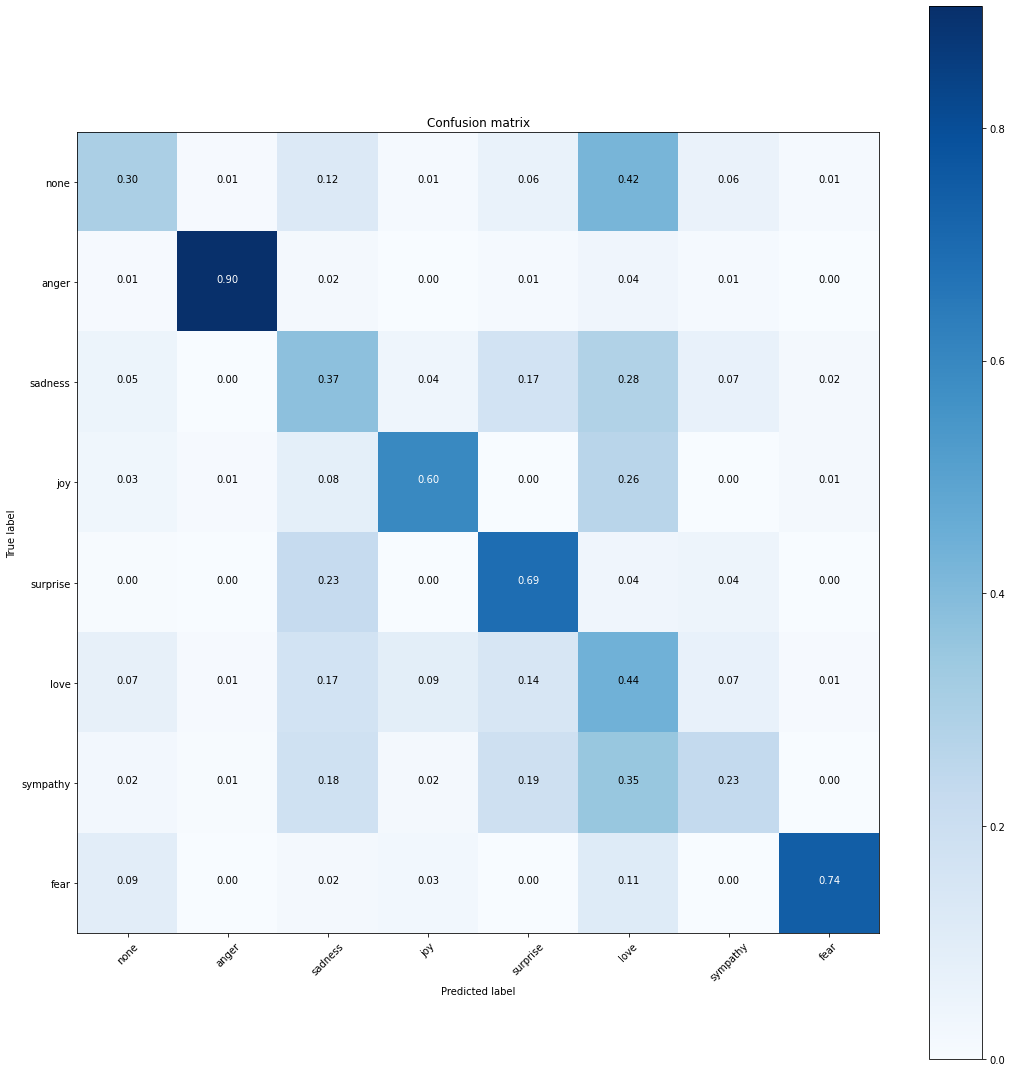

In [54]:
plot_confusion_matrix(cm, list(df[" LABEL"].unique().tolist()) ,True)

In [37]:
def traslate_label(label):
  if label == 0:
    return "غضب"
  if label == 1:
    return "خوف"
  if label == 2:
    return "فرح"
  if label == 3:
    return "حب"
  if label == 4:
    return "طبيعي"
  if label == 5:
    return "حزين"
  if label == 6:
    return "متفاجئ" 
  if label == 7:
    return "تعاطف"

In [38]:
def predict_doc(text):  
    embedded_vector = encoded_docs(text)

    arr = np.zeros(shape=(1, embedded_vector.shape[0], embedded_vector.shape[1]))
    arr[0] = np.array(embedded_vector)
    softmax_prediction = model.predict(arr)

    return traslate_label(np.argmax(softmax_prediction))

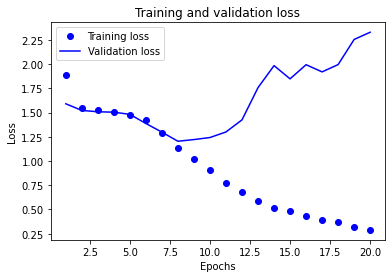

In [40]:
history_dict = history.history
history_dict.keys()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

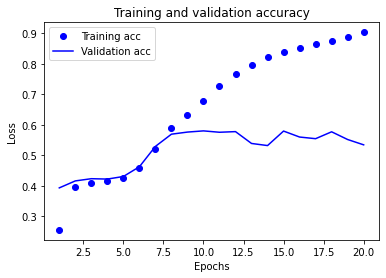

In [41]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [47]:
doc = input("اكتب جملة: لمعرفة حالتها\n")
while True:
  if doc == 'break':
      print("الى اللقاء")
      break
  else:
      # preprocessing embedding predict 
      embedded_vector = encoded_docs(doc)
      shape= np.shape(embedded_vector)
      embedded_vector = np.array(embedded_vector).reshape(1,shape[0],shape[1])
      label = model.predict_classes(embedded_vector)
      textlabel = traslate_label(label)
      print ("الحالة:",textlabel)
      doc = input("")

اكتب جملة: لمعرفة حالتها
انا مش حزين
الحالة: فرح
الامتحان كان صعب جدا
الحالة: حزين
معقول كل ده حصل
الحالة: متفاجئ
هنكسب ماتش انهارده
الحالة: فرح
break
الى اللقاء
